# DNN with Embedding Layers & Multi Inputs

#### Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import random
import pickle
from IPython.display import Image
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

print(tf.__version__)

2.3.1


#### Set random seeds to make your results reproducible

In [2]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


### Load Data

In [3]:
df = pd.read_pickle(os.path.abspath("../dat")+'/features_조기흠.pkl')
test = pd.read_csv(os.path.abspath("../dat")+'/test.csv', encoding='cp949')
df

,month,item_id,item_cnt_month,category,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,month_item_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_2,...,week4_cat_avg_item_cnt_lag_2,week4_item_avg_item_cnt_lag_2,week5_cat_avg_item_cnt_lag_1,week5_item_avg_item_cnt_lag_1,week5_cat_avg_item_cnt_lag_2,week5_item_avg_item_cnt_lag_2,week6_cat_avg_item_cnt_lag_1,week6_item_avg_item_cnt_lag_1,week6_cat_avg_item_cnt_lag_2,week6_item_avg_item_cnt_lag_2
0,5,100000,1.0,잡지,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,100004,1.0,전집,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,100030,1.0,잡지,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,100038,1.0,청소년,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,100040,1.0,중고등학습서,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154598,12,203058,0.0,중고등학습서,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154599,12,203061,0.0,IT 모바일,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154600,12,203065,0.0,국어 외국어 사전,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154601,12,203068,0.0,수험서 자격증,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split Data

아래와 같이 데이터를 분할:
- Train Data: 5~11월 데이터
- Test Data: 12월 데이터

In [4]:
# object => numeric
df['category'] = df['category'].astype('category').cat.codes

In [5]:
df

,month,item_id,item_cnt_month,category,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,month_item_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_2,...,week4_cat_avg_item_cnt_lag_2,week4_item_avg_item_cnt_lag_2,week5_cat_avg_item_cnt_lag_1,week5_item_avg_item_cnt_lag_1,week5_cat_avg_item_cnt_lag_2,week5_item_avg_item_cnt_lag_2,week6_cat_avg_item_cnt_lag_1,week6_item_avg_item_cnt_lag_1,week6_cat_avg_item_cnt_lag_2,week6_item_avg_item_cnt_lag_2
0,5,100000,1.0,19,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,100004,1.0,20,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,100030,1.0,19,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,100038,1.0,23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,100040,1.0,22,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154598,12,203058,0.0,22,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154599,12,203061,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154600,12,203065,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154601,12,203068,0.0,10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from kydavra import LassoSelector

selector = LassoSelector()
selected_cols = selector.select(df.iloc[:,1:], 'item_cnt_month')

selected_cols.append('month')
selected_cols.append('item_cnt_month')
selected_cols.append('category')
selected_cols.append('item_id')
df = df[selected_cols]


In [7]:
df.columns

Index(['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'month_item_avg_item_cnt_lag_1',
       'month_item_avg_item_cnt_lag_3', 'month_item_avg_item_cnt_lag_4',
       'month_cat_avg_item_cnt_lag_1', 'month_cat_avg_item_cnt_lag_2',
       'month_cat_avg_item_cnt_lag_3', 'month_cat_avg_item_cnt_lag_4',
       'cat_delta_cnt_lag', 'month_aut_avg_item_cnt_lag_3',
       'month_aut_avg_item_cnt_lag_4', 'month_pub_avg_item_cnt_lag_1',
       'month_pub_avg_item_cnt_lag_3', 'month_pub_avg_item_cnt_lag_4',
       'pub_date_year', 'week1_cat_avg_item_cnt_lag_1',
       'week1_item_avg_item_cnt_lag_1', 'week1_cat_avg_item_cnt_lag_2',
       'week1_item_avg_item_cnt_lag_2', 'week2_cat_avg_item_cnt_lag_1',
       'week2_item_avg_item_cnt_lag_1', 'week2_cat_avg_item_cnt_lag_2',
       'week3_cat_avg_item_cnt_lag_1', 'week3_item_avg_item_cnt_lag_1',
       'week3_cat_avg_item_cnt_lag_2', 'week3_item_avg_item_cnt_lag_2',
       'week4_cat_avg_it

In [8]:
X_train = df[df.month < 12].drop(['item_cnt_month'], axis=1)
y_train = df[df.month < 12]['item_cnt_month']
X_test = df[df.month == 12].drop(['item_cnt_month'], axis=1)

In [9]:
# Categorical features
X_train_cat = np.array(X_train['category']).reshape(-1,1)
X_test_cat = np.array(X_test['category']).reshape(-1,1)

In [10]:
# Numerical features
X_train = X_train.drop(['month', 'category'], axis=1)
X_test = X_test.drop(['month', 'category'], axis=1)

In [11]:
X_train.shape, X_test.shape

((141122, 42), (13481, 42))

### Train & Evaluate the Model

Scale Data

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

DNN를 사용하여 모델링

In [13]:
# Define the NN architecture

input_num = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(64, activation = 'elu')(input_num)
x1 = keras.layers.Dense(64)(x)
x1 = keras.layers.Add()([x1,x])

input_cat = keras.Input(shape=(1,))
x = keras.layers.Embedding(np.unique(X_train_cat).size, 16)(input_cat)
x2 = keras.layers.Flatten()(x)

x = keras.layers.Concatenate()([x1, x2])
x = keras.layers.Dense(32, activation = 'elu')(x)
x = keras.layers.Dropout(0.1)(x)
x1 = keras.layers.Dense(32)(x)
x = keras.layers.Add()([x1,x])
x = keras.layers.Dense(8, activation = 'elu')(x)
x = keras.layers.Dropout(0.1)(x)
x1 = keras.layers.Dense(8)(x)
x = keras.layers.Add()([x1,x])
output = keras.layers.Dense(1, activation='relu')(x)
model = keras.Model([input_num,input_cat], output)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           2752        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
_______________________________________________________________________________________

In [14]:
model.compile(loss='mse', optimizer='nadam', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
hist = model.fit([X_train, X_train_cat], y_train, validation_split = 0.3, 
                 batch_size=1024, epochs=200, 
                 callbacks=callbacks, shuffle=False, verbose=2)

Epoch 1/200
97/97 - 0s - loss: 5.4978 - rmse: 2.3447 - val_loss: 5.0635 - val_rmse: 2.2502
Epoch 2/200
97/97 - 0s - loss: 4.5182 - rmse: 2.1256 - val_loss: 4.8874 - val_rmse: 2.2107
Epoch 3/200
97/97 - 0s - loss: 4.3487 - rmse: 2.0854 - val_loss: 4.8297 - val_rmse: 2.1977
Epoch 4/200
97/97 - 0s - loss: 4.2659 - rmse: 2.0654 - val_loss: 4.7865 - val_rmse: 2.1878
Epoch 5/200
97/97 - 0s - loss: 4.2247 - rmse: 2.0554 - val_loss: 4.8410 - val_rmse: 2.2002
Epoch 6/200
97/97 - 0s - loss: 4.2033 - rmse: 2.0502 - val_loss: 4.7836 - val_rmse: 2.1871
Epoch 7/200
97/97 - 0s - loss: 4.1754 - rmse: 2.0434 - val_loss: 4.8031 - val_rmse: 2.1916
Epoch 8/200
97/97 - 0s - loss: 4.1349 - rmse: 2.0334 - val_loss: 4.7745 - val_rmse: 2.1851
Epoch 9/200
97/97 - 0s - loss: 4.1225 - rmse: 2.0304 - val_loss: 4.7668 - val_rmse: 2.1833
Epoch 10/200
97/97 - 0s - loss: 4.1173 - rmse: 2.0291 - val_loss: 4.7649 - val_rmse: 2.1829
Epoch 11/200
97/97 - 0s - loss: 4.1122 - rmse: 2.0279 - val_loss: 4.7343 - val_rmse: 2.17

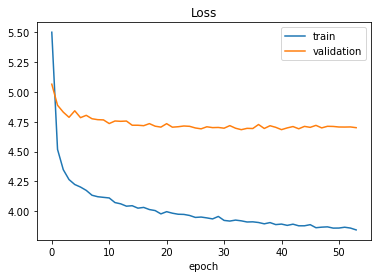

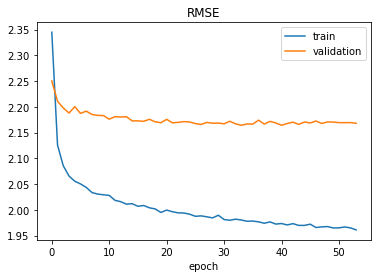

In [15]:
# Loss
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

# RMSE
plt.plot(hist.history["rmse"], label="train")
plt.plot(hist.history["val_rmse"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("RMSE")
plt.show()

### Make Submissions

In [16]:
pred = model.predict([X_test, X_test_cat])
submission = pd.DataFrame({
    "item_id": test.item_id, 
    "item_cnt_month": pred.clip(0, 20).flatten()
})
t = pd.Timestamp.now()
submission.to_csv(os.path.abspath("../dat")+'/조기흠_01.csv', encoding='cp949')

# End